#MODULE-1

#Accident Severity Prediction Using Machine Learning

In [2]:
import requests
import csv
import time

# API Key for The Guardian
guardian_key = "ee79cd97-ef16-4aea-ab5c-0dbcc87018d6"

# API Endpoint
guardian_endpoint = "https://content.guardianapis.com/search"

# Topics to fetch data
topics = [
    "road accident",
    "train accident",
    "airplane crash",
    "natural disaster",
    "fire accident",
    "industrial accident",
    "bike accident",
    "car collision",
    "truck accident",
    "boat accident",
    "bus accident",
    "subway accident",
    "construction site accident",
    "factory explosion",
    "mining accident",
    "power plant failure",
    "chemical spill",
    "oil rig disaster",
    "earthquake damage",
    "hurricane impact",
    "tsunami destruction",
    "landslide accident",
    "volcanic eruption",
    "flooding disaster",
    "severe storm damage",
    "avalanche accident",
    "residential fire",
    "gas leak explosion",
    "forest wildfire",
    "electrical fire",
    "industrial plant fire",
    "warehouse fire",
    "mass casualty incident",
    "hospital emergency evacuation",
    "building collapse",
    "bridge collapse",
    "dam failure",
    "toxic gas exposure",
    "radiation leak accident"
]

# Output file
filename = "guardian_accidents_data.csv"

# Open CSV file and write headers
with open(filename, mode="w", newline="", encoding="utf-8") as MyFILE:
    csv_writer = csv.writer(MyFILE)
    csv_writer.writerow(["Label", "Source", "Title", "Description", "Published At", "URL", "Content"])

    for topic in topics:
        print(f"Fetching data for: {topic}")

        for page in range(1, 6):  # Fetch up to 5 pages per topic
            params = {
                'api-key': guardian_key,
                'q': topic,
                'page-size': 100,
                'page': page,
                'order-by': 'relevance',  # Can change to 'newest' or 'oldest'
                'show-fields': 'headline,bodyText,publication'  # Get full text if available
            }

            try:
                response = requests.get(guardian_endpoint, params=params)
                if response.status_code == 200:
                    jsontxt = response.json()
                    if "response" not in jsontxt or "results" not in jsontxt["response"] or not jsontxt["response"]["results"]:
                        print(f"No more data for {topic} on page {page} (The Guardian).")
                        break

                    for article in jsontxt["response"]["results"]:
                        label = topic
                        source = article.get("sectionName", "The Guardian")
                        title = article.get("webTitle", "N/A")
                        description = article.get("fields", {}).get("bodyText", "N/A")[:250]  # Get only the first 250 chars
                        published_at = article.get("webPublicationDate", "N/A")
                        url = article.get("webUrl", "N/A")
                        content = article.get("fields", {}).get("bodyText", "N/A")

                        if any(keyword in title.lower() for keyword in ["accident", "crash", "collision", "fire", "injured", "died"]):
                            csv_writer.writerow([label, source, title, description, published_at, url, content])

                    print(f"The Guardian API: Page {page} collected for {topic}")

                else:
                    print(f"The Guardian API failed for {topic}, Status Code: {response.status_code}")
                    break  # Stop requesting pages if there's an error

                time.sleep(2)  # Sleep to avoid rate limits

            except Exception as e:
                print(f"Error fetching data for {topic} from The Guardian API on page {page}: {e}")
                break

print(f"News articles successfully written to {filename}.")


Fetching data for: road accident
The Guardian API: Page 1 collected for road accident
The Guardian API: Page 2 collected for road accident
The Guardian API: Page 3 collected for road accident
The Guardian API: Page 4 collected for road accident
The Guardian API: Page 5 collected for road accident
Fetching data for: train accident
The Guardian API: Page 1 collected for train accident
The Guardian API: Page 2 collected for train accident
The Guardian API: Page 3 collected for train accident
The Guardian API: Page 4 collected for train accident
The Guardian API: Page 5 collected for train accident
Fetching data for: airplane crash
The Guardian API: Page 1 collected for airplane crash
The Guardian API: Page 2 collected for airplane crash
The Guardian API: Page 3 collected for airplane crash
The Guardian API: Page 4 collected for airplane crash
The Guardian API: Page 5 collected for airplane crash
Fetching data for: natural disaster
The Guardian API: Page 1 collected for natural disaster
Th

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from textblob import TextBlob

# Load dataset
file_path = "guardian_accidents_data.csv"
df_raw = pd.read_csv(file_path)



In [3]:
# Display dataset info before preprocessing
print("Dataset Overview Before Preprocessing")
print("Number of Rows:", df_raw.shape[0])
print("Number of Columns:", df_raw.shape[1])
print("Column Names:", df_raw.columns.tolist())
print("Missing Values:\n", df_raw.isnull().sum())
print("Duplicate Entries:", df_raw.duplicated().sum())

Dataset Overview Before Preprocessing
Number of Rows: 4707
Number of Columns: 7
Column Names: ['Label', 'Source', 'Title', 'Description', 'Published At', 'URL', 'Content']
Missing Values:
 Label           0
Source          0
Title           0
Description     0
Published At    0
URL             0
Content         0
dtype: int64
Duplicate Entries: 18


In [4]:
# Convert 'Published At' to datetime
df_raw['Published At'] = pd.to_datetime(df_raw['Published At'], errors='coerce')

In [5]:
# Dropping duplicates
df_cleaned = df_raw.drop_duplicates()




In [6]:
# Removing columns that are not useful
columns_to_remove = ['URL']  # Example: removing URL column if not needed
df_cleaned.drop(columns=columns_to_remove, inplace=True, errors='ignore')



<ipython-input-6-66745abc8c58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.drop(columns=columns_to_remove, inplace=True, errors='ignore')


In [7]:
# Standardizing text fields (lowercasing, removing special characters)
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r'\W+', ' ', text)
        return text.strip()
    return text

In [8]:
df_cleaned['Title'] = df_cleaned['Title'].apply(clean_text)
df_cleaned['Description'] = df_cleaned['Description'].apply(clean_text)
df_cleaned['Content'] = df_cleaned['Content'].apply(clean_text)

<ipython-input-8-1927760ff68e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Title'] = df_cleaned['Title'].apply(clean_text)
<ipython-input-8-1927760ff68e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Description'] = df_cleaned['Description'].apply(clean_text)
<ipython-input-8-1927760ff68e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [9]:

# Checking for incorrect outliers
num_cols = df_cleaned.select_dtypes(include=[np.number]).columns
df_cleaned[num_cols] = df_cleaned[num_cols].apply(lambda x: x.clip(lower=x.quantile(0.01), upper=x.quantile(0.99)))
print("\nData after handling outliers:")
print(df_cleaned.describe())


Data after handling outliers:
                Label   Source  \
count            4689     4689   
unique             39       32   
top     fire accident  US news   
freq              444     1062   
mean              NaN      NaN   
min               NaN      NaN   
25%               NaN      NaN   
50%               NaN      NaN   
75%               NaN      NaN   
max               NaN      NaN   

                                                    Title  \
count                                                4689   
unique                                               1305   
top     the huge us toxic fire shrouded in secrecy i t...   
freq                                                   22   
mean                                                  NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                          

In [10]:
# Sentiment Analysis
df_cleaned['Sentiment'] = df_cleaned['Description'].apply(lambda x: TextBlob(x).sentiment.polarity)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_cleaned['Content'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Combine with original dataset
df_final = pd.concat([df_cleaned.reset_index(drop=True), tfidf_df], axis=1)

# Display dataset info after preprocessing
print("\nDataset Overview After Preprocessing")
print("Dataset Shape After Cleaning:", df_final.shape)
print("Number of Features Added:", len(tfidf_df.columns) + 1)  # +1 for Sentiment

# Convert 'Published At' to index for time-based analysis
df_final['Published At'] = pd.to_datetime(df_final['Published At'])
df_final.set_index('Published At', inplace=True)

# Create additional time-based features
df_final['Month'] = df_final.index.month
df_final['Day of Week'] = df_final.index.dayofweek  # 0 = Monday, 6 = Sunday
df_final['Hour'] = df_final.index.hour


<ipython-input-10-80d2ca9572fe>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Sentiment'] = df_cleaned['Description'].apply(lambda x: TextBlob(x).sentiment.polarity)



Dataset Overview After Preprocessing
Dataset Shape After Cleaning: (4689, 507)
Number of Features Added: 501


In [11]:
# Saving cleaned dataset
cleaned_file_path = "accidents_cleaned.csv"  # Saves in the current working directory
df_final.to_csv(cleaned_file_path, index=False)

In [12]:
df_final.head()

,Label,Source,Title,Description,Content,Sentiment,000,10,100,11,...,world,worst,wrote,year,years,york,young,Month,Day of Week,Hour
Published At,,,,,,,,,,,,,,,,,,,,,
2025-01-28 16:31:02+00:00,road accident,UK news,leicester city helicopter crash ruled an accid...,the deaths of five people including the former...,the deaths of five people including the former...,-0.066667,0.0,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.000000,0.066992,0.000000,0.000000,1,1,16
2024-11-19 11:43:23+00:00,road accident,UK news,heavy snowfall across the uk as schools closed...,we re closing this live blog now thanks for re...,we re closing this live blog now thanks for re...,0.117172,0.0,0.072476,0.00000,0.023626,...,0.0,0.050184,0.0,0.000000,0.000000,0.000000,0.000000,11,1,11
2024-12-07 17:44:19+00:00,road accident,Football,west ham s michail antonio in stable condition...,west ham united have asked for privacy for mic...,west ham united have asked for privacy for mic...,-0.150000,0.0,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,12,5,17
2025-01-19 20:51:47+00:00,road accident,Australia news,two teenagers die after sunshine coast waterfa...,two 17 year olds have died in the sunshine coa...,two 17 year olds have died in the sunshine coa...,0.000000,0.0,0.069630,0.08855,0.000000,...,0.0,0.000000,0.0,0.182648,0.000000,0.000000,0.092382,1,6,20
2024-11-12 14:03:06+00:00,road accident,US news,huge response to fundraiser for former congres...,a fundraiser for a republican former congressm...,a fundraiser for a republican former congressm...,0.166667,0.0,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.000000,0.000000,0.475844,0.000000,11,1,14


#Visualization

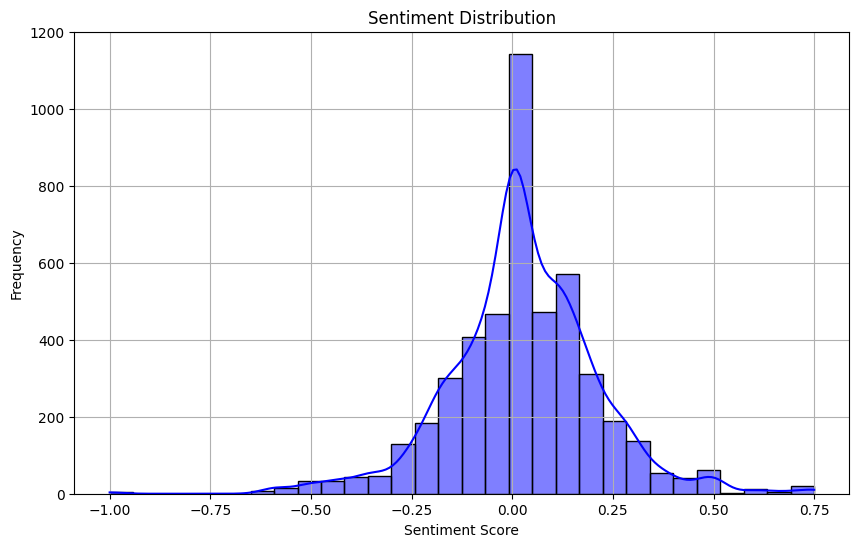

In [13]:
# Visualization 1: Sentiment Distribution

plt.figure(figsize=(10, 6))
sns.histplot(df_final['Sentiment'], bins=30, kde=True, color='blue')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<ipython-input-14-559e8e2350de>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_final['Label'].resample('M').count().plot(color='green', marker='o', linestyle='-')


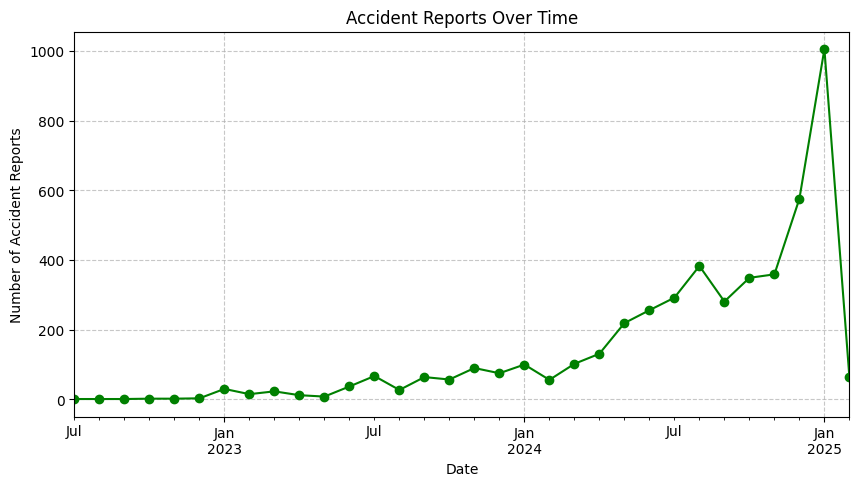

In [14]:
# Visualization 2: Accident Reports Over Time
plt.figure(figsize=(10, 5))
df_final['Label'].resample('M').count().plot(color='green', marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Number of Accident Reports')
plt.title('Accident Reports Over Time')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



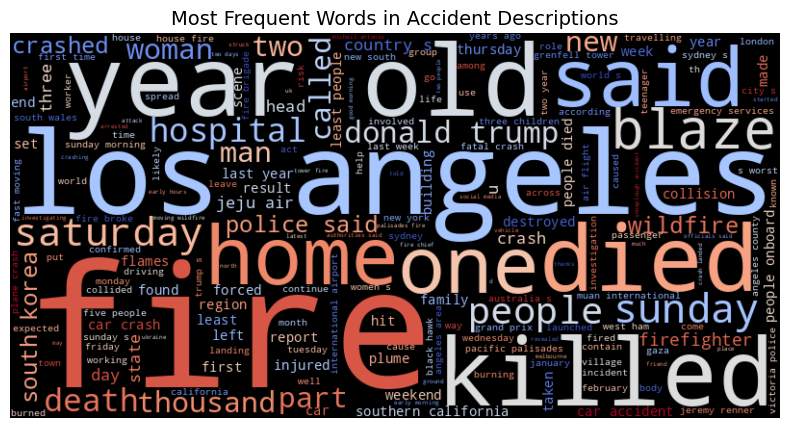

In [15]:
# Visualization 3: Word Cloud for Accident Descriptions
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='coolwarm').generate(" ".join(df_final['Description'].dropna()))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Accident Descriptions', fontsize=14)
plt.show()



<ipython-input-16-97d21a16acb9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_final['Source'], order=df_final['Source'].value_counts().index, palette='coolwarm')


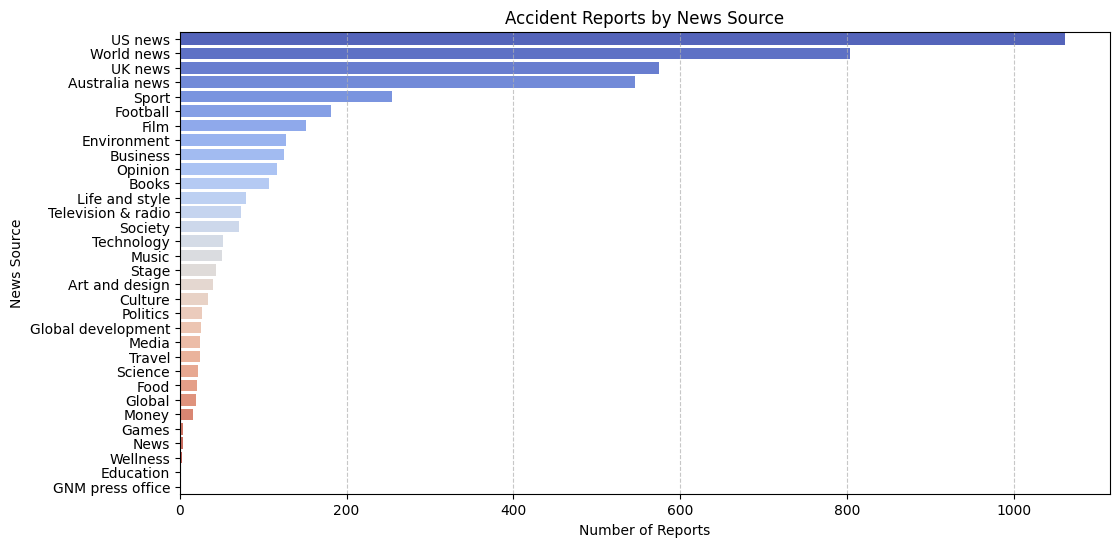

In [16]:
# Visualization 4: Accident Reports by News Source
plt.figure(figsize=(12, 6))
sns.countplot(y=df_final['Source'], order=df_final['Source'].value_counts().index, palette='coolwarm')
plt.xlabel('Number of Reports')
plt.ylabel('News Source')
plt.title('Accident Reports by News Source')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



<ipython-input-17-98e8a586f68f>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=word_freq_df['Word'], x=word_freq_df['Frequency'], palette='magma')


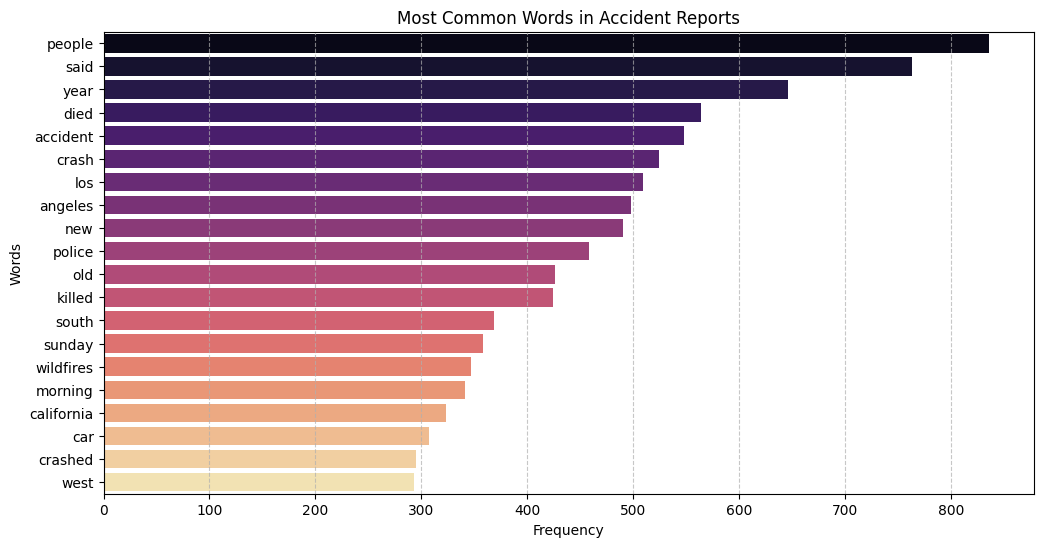

In [17]:
# Visualization 5: Most Common Words in Severe Accidents
vectorizer = CountVectorizer(stop_words='english', max_features=20)
word_matrix = vectorizer.fit_transform(df_final['Description'])
word_counts = np.asarray(word_matrix.sum(axis=0)).flatten()
word_freq_df = pd.DataFrame({'Word': vectorizer.get_feature_names_out(), 'Frequency': word_counts}).sort_values(by='Frequency', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(y=word_freq_df['Word'], x=word_freq_df['Frequency'], palette='magma')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Most Common Words in Accident Reports')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



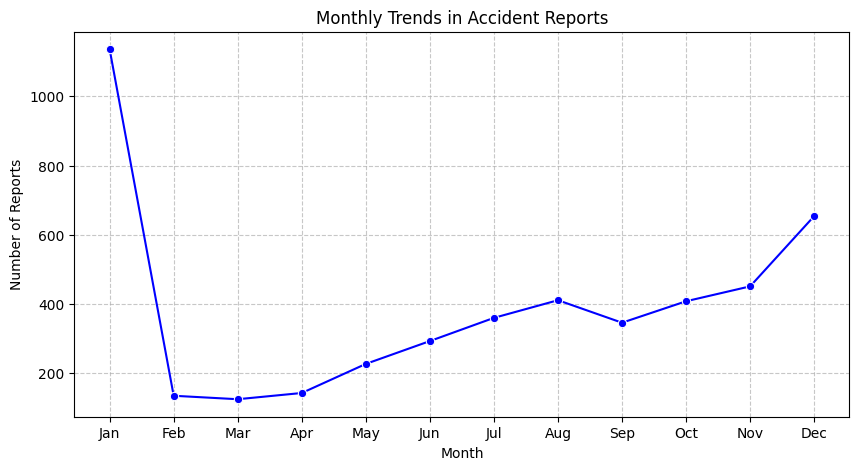

In [18]:
# Visualization 6: Monthly Trends in Accident Reports
monthly_trends = df_final.groupby('Month')['Label'].count()
plt.figure(figsize=(10, 5))
sns.lineplot(x=monthly_trends.index, y=monthly_trends.values, marker='o', color='blue')
plt.xlabel('Month')
plt.ylabel('Number of Reports')
plt.title('Monthly Trends in Accident Reports')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



<ipython-input-19-3d534f5151b8>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df_final['Source'], x=df_final['Sentiment'], palette='viridis', showfliers=False)


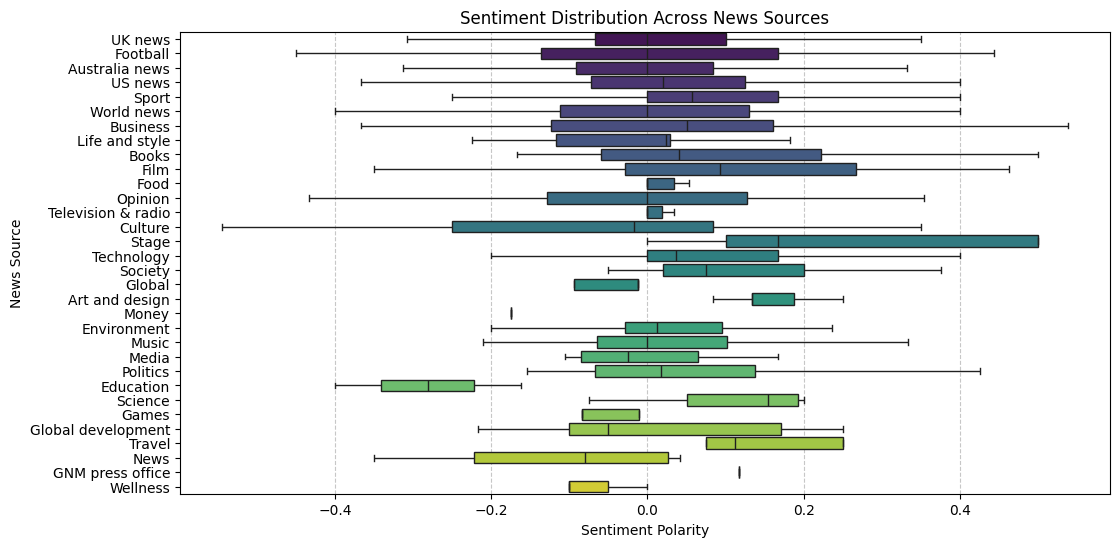

In [19]:
# Visualization 7: Sentiment Distribution Across News Sources
plt.figure(figsize=(12, 6))
sns.boxplot(y=df_final['Source'], x=df_final['Sentiment'], palette='viridis', showfliers=False)
plt.xlabel('Sentiment Polarity')
plt.ylabel('News Source')
plt.title('Sentiment Distribution Across News Sources')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()



<ipython-input-20-17edcfc718bc>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_counts.index, y=day_counts.values, palette='plasma')


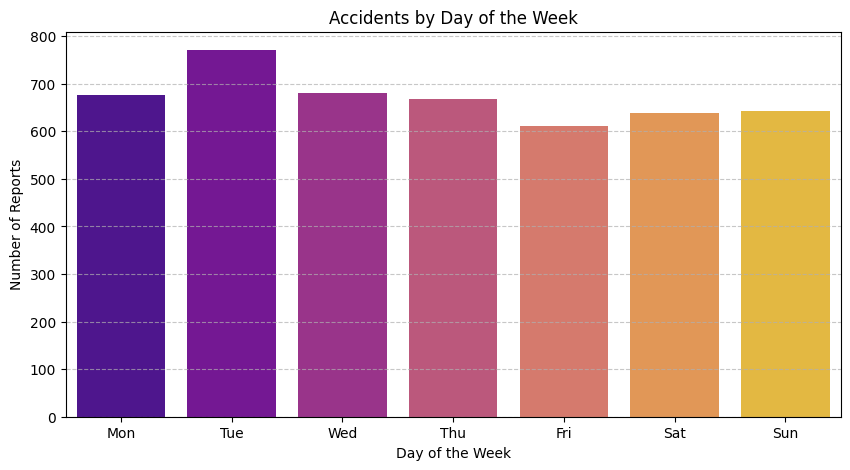

In [20]:
# Visualization 8: Accidents by Day of the Week
day_counts = df_final.groupby('Day of Week')['Label'].count()
plt.figure(figsize=(10, 5))
sns.barplot(x=day_counts.index, y=day_counts.values, palette='plasma')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Reports')
plt.title('Accidents by Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



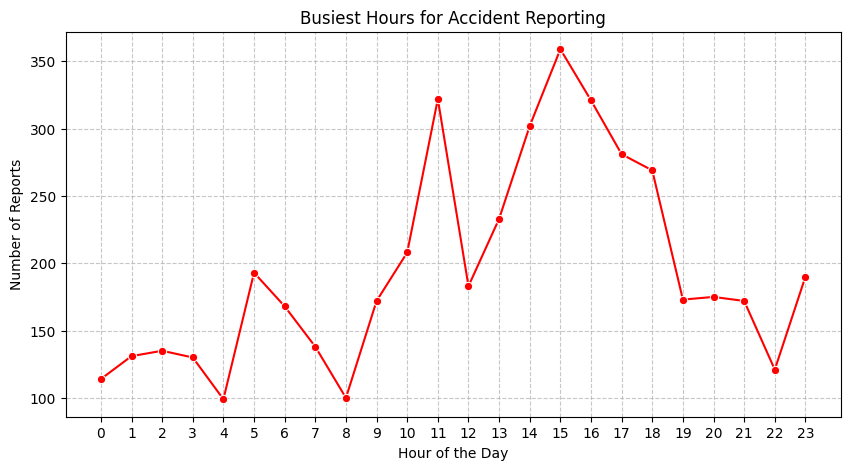

In [21]:
# Visualization 9: Busiest Hours for Accident Reporting
hourly_counts = df_final.groupby('Hour')['Label'].count()
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_counts.index, y=hourly_counts.values, marker='o', color='red')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Reports')
plt.title('Busiest Hours for Accident Reporting')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



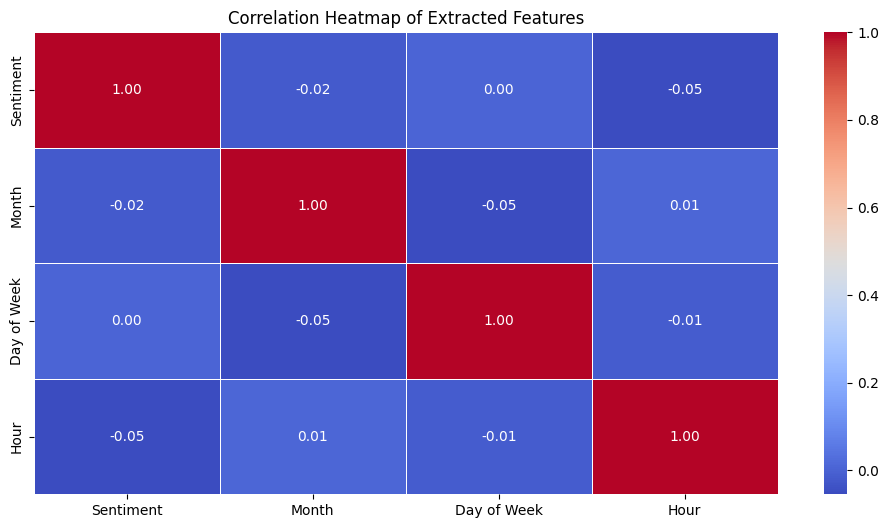

In [22]:
# Visualization 10: Correlation Heatmap of Extracted Features
plt.figure(figsize=(12, 6))
correlation_matrix = df_final[['Sentiment', 'Month', 'Day of Week', 'Hour']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Extracted Features')
plt.show()

<ipython-input-27-106e2b202de6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df_final['Sentiment'], y=df_final['Label'], palette='coolwarm')


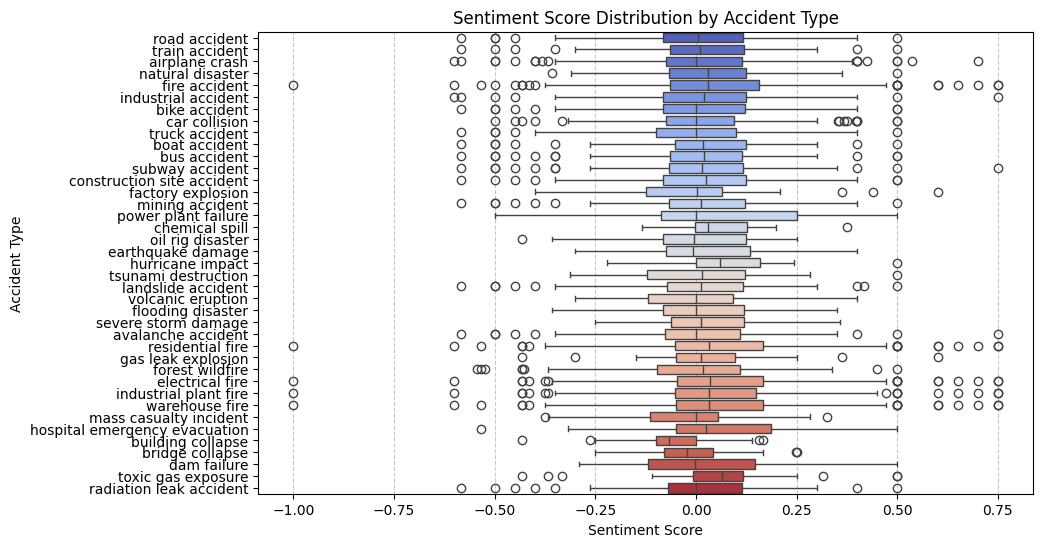

In [27]:
# Visualization 11: Sentiment Score by Accident Type
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_final['Sentiment'], y=df_final['Label'], palette='coolwarm')
plt.xlabel('Sentiment Score')
plt.ylabel('Accident Type')
plt.title('Sentiment Score Distribution by Accident Type')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()